# Notebook 3 -- Ameliorations methodologiques et analyses avancees

## Objectif

Ce notebook adresse les limites identifiees dans le paper de reference et dans le Notebook 2, 
en implementant des ameliorations methodologiques :

1. **Analyse en Composantes Principales (ACP)** avant clustering : reduction de dimension 
   et decorrelation des variables
2. **Methodes de clustering alternatives** :
   - DBSCAN (density-based) : detection de clusters de forme arbitraire et d'outliers
   - Gaussian Mixture Models (GMM) : clustering probabiliste avec clusters ellipso\u00efdaux
3. **Analyse temporelle des clusters** : comment les affectations evoluent-elles dans le temps ?
4. **Distances alternatives** : Manhattan, correlation, cosinus
5. **Validation croisee du clustering** (bootstrap)
6. **Interpretation financiere** et synthese

## Pre-requis

Executer les Notebooks 1 et 2 au prealable.

---
## 1. Imports et chargement

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cm import get_cmap
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    silhouette_score, silhouette_samples,
    calinski_harabasz_score, davies_bouldin_score,
    adjusted_rand_score, normalized_mutual_info_score
)
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14, 7)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
sns.set_style('whitegrid')

TICKER_NAMES = {
    'NVDA US Equity': 'NVIDIA', 'AVGO US Equity': 'Broadcom',
    'TSM US Equity': 'TSMC', 'GOOGL US Equity': 'Alphabet',
    '000660 KS Equity': 'SK Hynix', 'LRCX US Equity': 'Lam Research',
    '6857 JP Equity': 'Advantest', 'TSEM IT Equity': 'Tower Semi',
    'MSFT US Equity': 'Microsoft', 'LITE US Equity': 'Lumentum',
    'AMD US Equity': 'AMD', 'FN US Equity': 'Fabrinet',
    'SNOW US Equity': 'Snowflake', 'MU US Equity': 'Micron',
    'TSLA US Equity': 'Tesla', '9984 JP Equity': 'SoftBank',
    'CRDO US Equity': 'CREDO Tech', 'ENR GR Equity': 'Siemens Energy',
    'MPWR US Equity': 'Monolithic Power', '2383 TT Equity': 'Elite Material',
    'CLS CN Equity': 'Celestica', 'META US Equity': 'Meta',
    'AMZN US Equity': 'Amazon'
}

print('Imports effectues.')

Imports effectues.


In [3]:
# Chargement des donnees
df_env = pd.read_csv('../data/clean/notebook1/env_score_clean.csv', parse_dates=['Date'])
df_soc = pd.read_csv('../data/clean/notebook1/soc_score_clean.csv', parse_dates=['Date'])
df_esg = pd.read_csv('../data/clean/notebook1/esg_score_clean.csv', parse_dates=['Date'])

mat_niveaux = pd.read_csv('../data/clean/notebook2/clustering_niveaux.csv', index_col=0)
mat_var = pd.read_csv('../data/clean/notebook2/clustering_variations.csv', index_col=0)
X_scaled_df = pd.read_csv('../data/clean/notebook2/scores_standardises.csv', index_col=0)

features = ['Env_Score', 'Soc_Score', 'ESG_Score']
X_scaled = X_scaled_df.values

print(f"Donnees chargees : {X_scaled.shape[0]} entreprises, {X_scaled.shape[1]} variables")

Donnees chargees : 23 entreprises, 3 variables


---
## 2. Analyse en Composantes Principales (ACP)

### Justification

L'ACP est une technique de reduction de dimension qui transforme les variables originales 
(potentiellement correlees) en composantes principales orthogonales. Dans notre contexte :

- Les scores Environnemental, Social et ESG global sont construits de maniere a ce que le score 
  ESG soit une combinaison ponderee des piliers. Il existe donc une correlation structurelle.
- L'ACP permet d'identifier les axes de variance principaux et de reduire le bruit.
- Le clustering sur les composantes principales peut etre plus robuste que sur les variables originales.

### Choix du nombre de composantes

On utilise le critere de Kaiser (valeurs propres > 1 sur donnees standardisees) 
et le critere du coude sur le scree plot.

In [4]:
# ACP complete (3 composantes)
pca_full = PCA(n_components=3)
X_pca_full = pca_full.fit_transform(X_scaled)

# Resultats
print("=== Analyse en Composantes Principales ===")
print(f"\nValeurs propres (variance expliquee) :")
for i, (var, ratio) in enumerate(zip(pca_full.explained_variance_, 
                                      pca_full.explained_variance_ratio_)):
    print(f"  PC{i+1} : valeur propre = {var:.3f}, variance expliquee = {ratio*100:.1f}%")

print(f"\nVariance cumulee :")
cumvar = np.cumsum(pca_full.explained_variance_ratio_)
for i, cv in enumerate(cumvar):
    print(f"  PC1-PC{i+1} : {cv*100:.1f}%")

=== Analyse en Composantes Principales ===

Valeurs propres (variance expliquee) :
  PC1 : valeur propre = 2.629, variance expliquee = 83.8%
  PC2 : valeur propre = 0.482, variance expliquee = 15.4%
  PC3 : valeur propre = 0.025, variance expliquee = 0.8%

Variance cumulee :
  PC1-PC1 : 83.8%
  PC1-PC2 : 99.2%
  PC1-PC3 : 100.0%


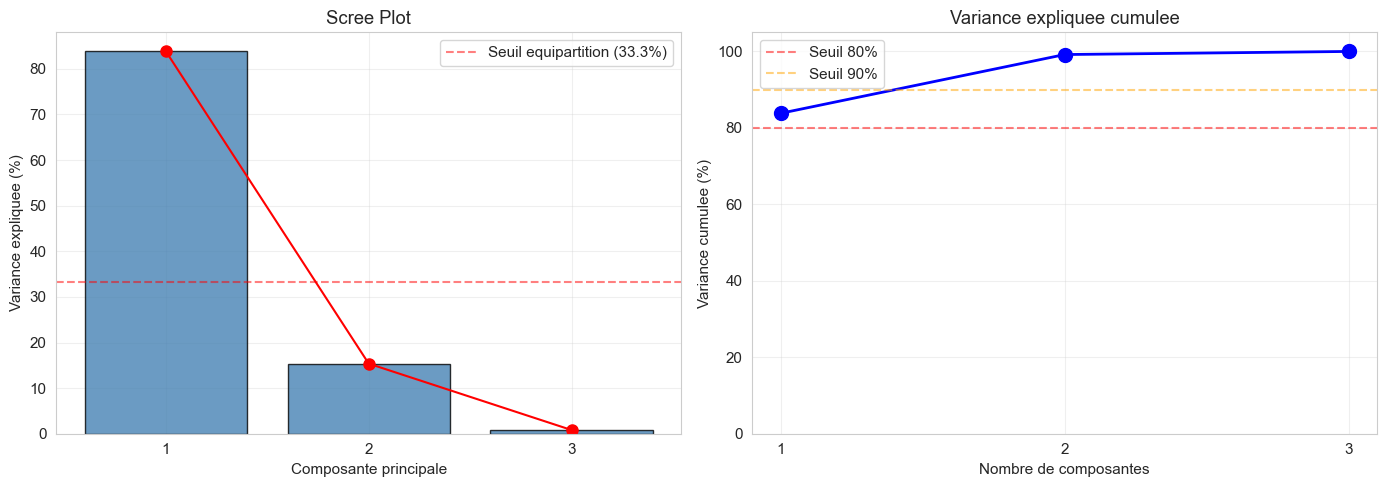

In [5]:
# Scree plot et variance cumulee
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].bar(range(1, 4), pca_full.explained_variance_ratio_ * 100, 
            color='steelblue', edgecolor='black', alpha=0.8)
axes[0].plot(range(1, 4), pca_full.explained_variance_ratio_ * 100, 'ro-', markersize=8)
axes[0].axhline(y=100/3, color='red', linestyle='--', alpha=0.5, 
                label='Seuil equipartition (33.3%)')
axes[0].set_xlabel('Composante principale')
axes[0].set_ylabel('Variance expliquee (%)')
axes[0].set_title('Scree Plot')
axes[0].set_xticks([1, 2, 3])
axes[0].legend()

# Variance cumulee
axes[1].plot(range(1, 4), cumvar * 100, 'bo-', linewidth=2, markersize=10)
axes[1].axhline(y=80, color='red', linestyle='--', alpha=0.5, label='Seuil 80%')
axes[1].axhline(y=90, color='orange', linestyle='--', alpha=0.5, label='Seuil 90%')
axes[1].set_xlabel('Nombre de composantes')
axes[1].set_ylabel('Variance cumulee (%)')
axes[1].set_title('Variance expliquee cumulee')
axes[1].set_xticks([1, 2, 3])
axes[1].set_ylim([0, 105])
axes[1].legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/03_pca_scree.png', dpi=150, bbox_inches='tight')
plt.show()

Matrice des loadings (contributions des variables aux composantes) :
             PC1    PC2    PC3
Env_Score  0.548  0.723 -0.421
Soc_Score  0.555 -0.690 -0.464
ESG_Score  0.626 -0.020  0.780


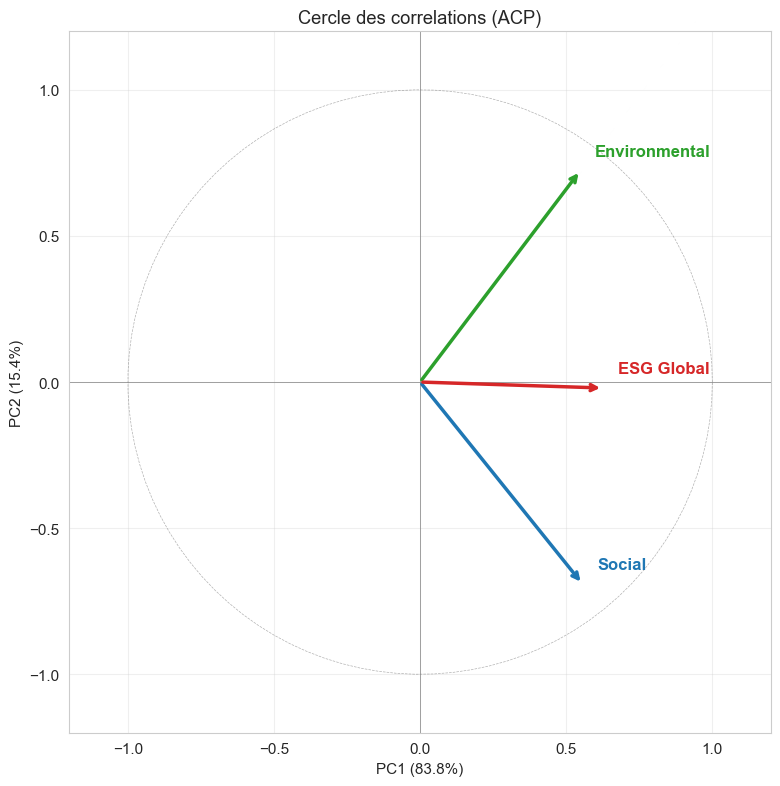

In [6]:
# Cercle des correlations (loadings)
loadings = pca_full.components_.T  # (n_features, n_components)
loading_df = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=features)

print("Matrice des loadings (contributions des variables aux composantes) :")
print(loading_df.round(3).to_string())

fig, ax = plt.subplots(figsize=(8, 8))

# Cercle unite
theta = np.linspace(0, 2 * np.pi, 100)
ax.plot(np.cos(theta), np.sin(theta), 'k--', linewidth=0.5, alpha=0.3)

# Fleches des variables
colors = ['#2ca02c', '#1f77b4', '#d62728']
labels_var = ['Environmental', 'Social', 'ESG Global']
for i, (feat, label, color) in enumerate(zip(features, labels_var, colors)):
    ax.annotate('', xy=(loadings[i, 0], loadings[i, 1]), xytext=(0, 0),
                arrowprops=dict(arrowstyle='->', color=color, lw=2.5))
    offset = 0.05
    ax.text(loadings[i, 0] + offset, loadings[i, 1] + offset, label,
            fontsize=12, color=color, fontweight='bold')

ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])
ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('Cercle des correlations (ACP)')
ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('../notebooks/figures/03_pca_cercle_correlations.png', dpi=150, bbox_inches='tight')
plt.show()

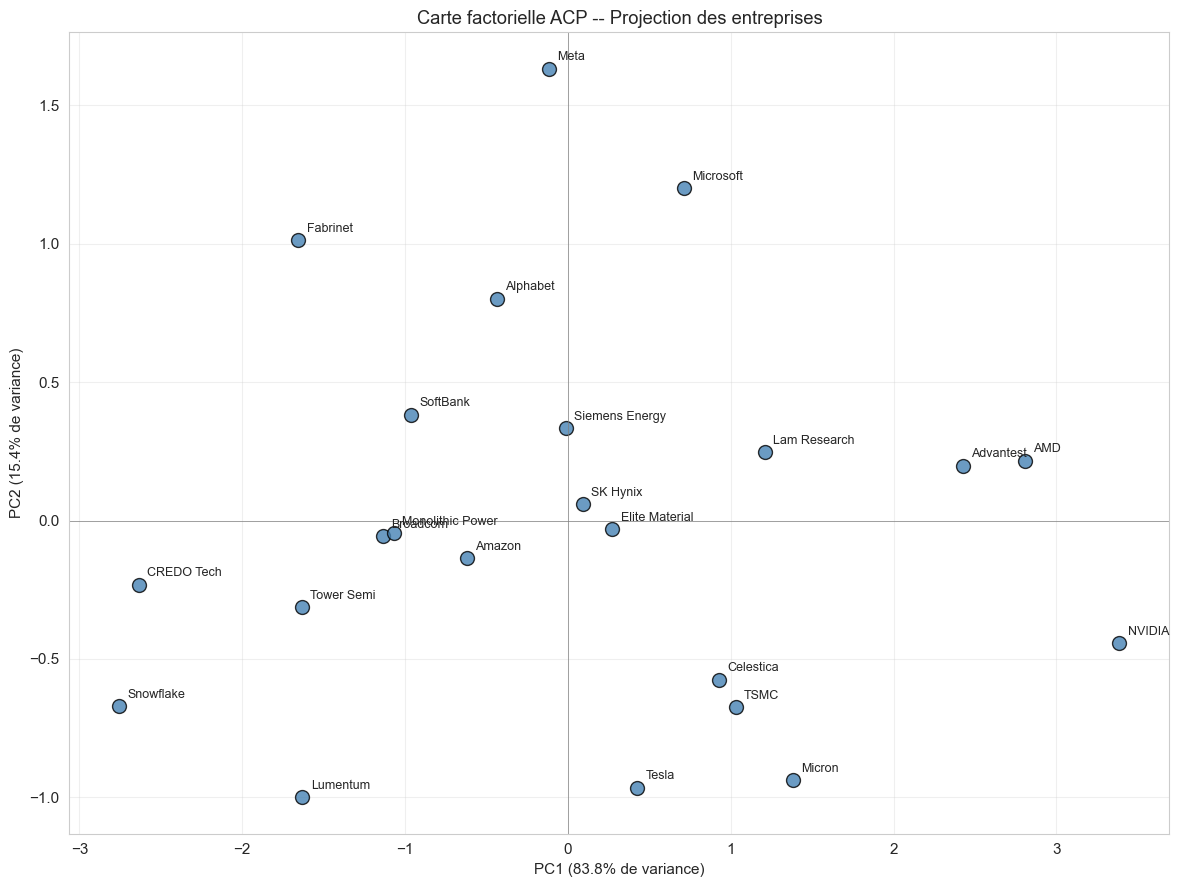

In [7]:
# Projection des individus sur le plan PC1-PC2
fig, ax = plt.subplots(figsize=(12, 9))

ax.scatter(X_pca_full[:, 0], X_pca_full[:, 1], s=100, c='steelblue', 
           edgecolors='black', alpha=0.8)

for i, ticker in enumerate(X_scaled_df.index):
    name = TICKER_NAMES.get(ticker, ticker)
    ax.annotate(name, (X_pca_full[i, 0], X_pca_full[i, 1]),
                textcoords='offset points', xytext=(6, 6), fontsize=9)

ax.axhline(y=0, color='gray', linewidth=0.5)
ax.axvline(x=0, color='gray', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}% de variance)')
ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}% de variance)')
ax.set_title('Carte factorielle ACP -- Projection des entreprises')

plt.tight_layout()
plt.savefig('../notebooks/figures/03_pca_individus.png', dpi=150, bbox_inches='tight')
plt.show()

### Clustering sur les composantes principales

On applique K-means et CAH sur les composantes principales retenues (PC1, PC2) 
puis on compare les resultats avec ceux obtenus sur les variables originales.

In [8]:
# Determination du nombre de composantes a retenir
# Critere : on retient les composantes dont la variance expliquee cumulee depasse 80%
n_components = np.argmax(cumvar >= 0.80) + 1
print(f"Nombre de composantes retenues (>=80% variance) : {n_components}")

# Si on n'a que 3 variables, 2 composantes suffisent generalement
n_components = min(n_components, 2)
X_pca = X_pca_full[:, :n_components]
print(f"Composantes utilisees pour le clustering : PC1 a PC{n_components}")
print(f"Variance totale retenue : {cumvar[n_components-1]*100:.1f}%")

# K-means sur ACP
K_range = range(2, min(8, len(X_pca)))
sil_pca = []
for k in K_range:
    km_pca = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels_pca = km_pca.fit_predict(X_pca)
    sil_pca.append(silhouette_score(X_pca, labels_pca))

k_opt_pca = list(K_range)[np.argmax(sil_pca)]
print(f"\nK optimal sur ACP : k = {k_opt_pca} (silhouette = {max(sil_pca):.3f})")

# Application
km_pca_final = KMeans(n_clusters=k_opt_pca, n_init=50, random_state=42)
labels_pca = km_pca_final.fit_predict(X_pca)

Nombre de composantes retenues (>=80% variance) : 1
Composantes utilisees pour le clustering : PC1 a PC1
Variance totale retenue : 83.8%

K optimal sur ACP : k = 6 (silhouette = 0.642)


Concordance clustering original vs clustering ACP :
  ARI = 0.562
  Interpretation : concordance moderee


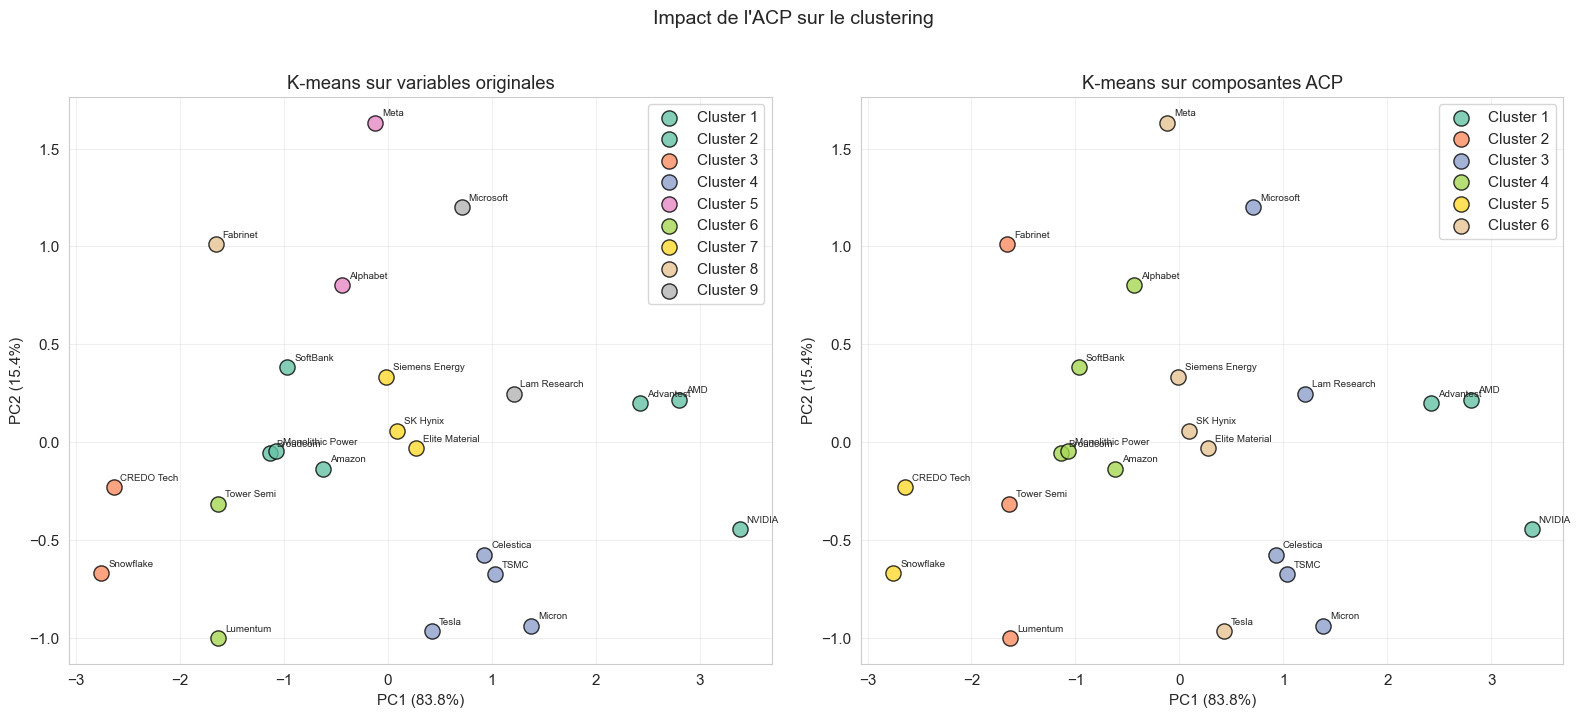

In [9]:
# Comparaison clustering original vs clustering sur ACP
labels_original = mat_niveaux['Cluster_KM'].values
ari_pca_vs_original = adjusted_rand_score(labels_original, labels_pca)

print(f"Concordance clustering original vs clustering ACP :")
print(f"  ARI = {ari_pca_vs_original:.3f}")
print(f"  Interpretation : {'forte concordance' if ari_pca_vs_original > 0.7 else 'concordance moderee' if ari_pca_vs_original > 0.4 else 'faible concordance'}")

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
cmap = get_cmap('Set2')

for ax, (labels, titre) in zip(axes, [
    (labels_original, 'K-means sur variables originales'),
    (labels_pca + 1, 'K-means sur composantes ACP')
]):
    for c in sorted(np.unique(labels)):
        mask = labels == c
        ax.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1],
                   c=[cmap((c-1)/max(np.unique(labels)))], label=f'Cluster {c}', s=120,
                   edgecolors='black', linewidth=1, alpha=0.8)
    
    for i, name in enumerate(mat_niveaux['Entreprise'].values):
        ax.annotate(name, (X_pca_full[i, 0], X_pca_full[i, 1]),
                    textcoords='offset points', xytext=(5, 5), fontsize=7)
    
    ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title(titre)
    ax.legend()

plt.suptitle('Impact de l\'ACP sur le clustering', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('../notebooks/figures/03_pca_clustering_comparaison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 3. DBSCAN -- Clustering par densite

### Motivation

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) ne suppose pas 
de forme particuliere pour les clusters et detecte automatiquement les outliers (points 
de bruit). C'est une amelioration par rapport au K-means qui impose des clusters spheriques.

### Parametres
- `eps` : rayon du voisinage
- `min_samples` : nombre minimum de points dans le voisinage pour former un cluster

On optimise ces parametres par recherche en grille.

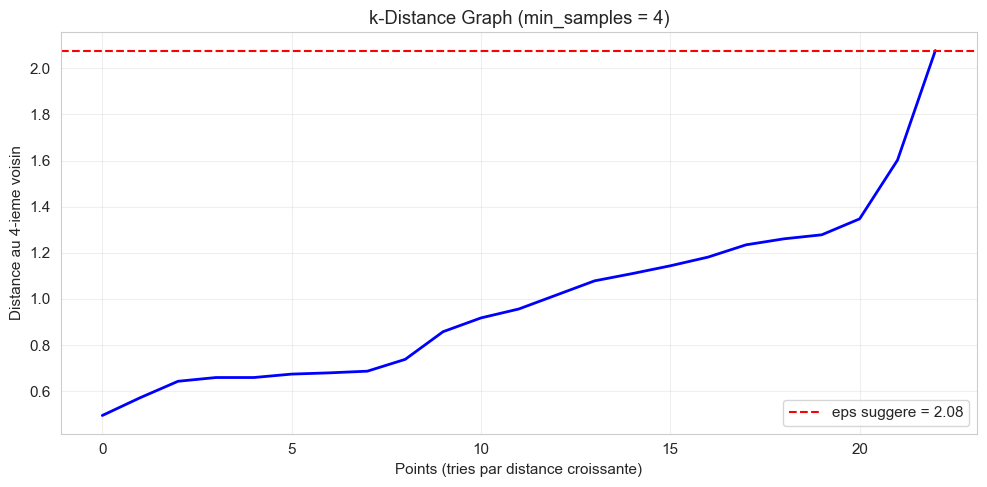

eps suggere par le k-distance graph : 2.08


In [10]:
# Analyse du k-distance graph pour choisir eps
from sklearn.neighbors import NearestNeighbors

# Pour min_samples = nombre de dimensions + 1 (regle empirique)
min_samples_default = X_scaled.shape[1] + 1  # 4

nn = NearestNeighbors(n_neighbors=min_samples_default)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
k_distances = np.sort(distances[:, -1])  # Distance au k-ieme voisin

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(len(k_distances)), k_distances, 'b-', linewidth=2)
ax.set_xlabel('Points (tries par distance croissante)')
ax.set_ylabel(f'Distance au {min_samples_default}-ieme voisin')
ax.set_title(f'k-Distance Graph (min_samples = {min_samples_default})')

# Identification du coude (approximatif)
# On cherche le point d'inflexion maximale
diffs = np.diff(k_distances)
elbow_idx = np.argmax(diffs) + 1
eps_suggestion = k_distances[elbow_idx]
ax.axhline(y=eps_suggestion, color='red', linestyle='--', 
           label=f'eps suggere = {eps_suggestion:.2f}')
ax.legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/03_dbscan_kdistance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"eps suggere par le k-distance graph : {eps_suggestion:.2f}")

In [11]:
# Recherche en grille pour DBSCAN
eps_values = np.arange(0.5, 3.5, 0.25)
min_samples_values = [2, 3, 4, 5]

dbscan_results = []

for eps in eps_values:
    for ms in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=ms)
        labels_db = db.fit_predict(X_scaled)
        n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
        n_noise = (labels_db == -1).sum()
        
        sil = np.nan
        if n_clusters >= 2 and n_noise < len(labels_db) - 1:
            # Silhouette sur les points non-bruit uniquement
            mask_non_noise = labels_db != -1
            if len(np.unique(labels_db[mask_non_noise])) >= 2:
                sil = silhouette_score(X_scaled[mask_non_noise], labels_db[mask_non_noise])
        
        dbscan_results.append({
            'eps': eps, 'min_samples': ms,
            'n_clusters': n_clusters, 'n_noise': n_noise,
            'silhouette': sil
        })

dbscan_df = pd.DataFrame(dbscan_results)
# Filtrer les configurations avec au moins 2 clusters
valid = dbscan_df[(dbscan_df['n_clusters'] >= 2) & (dbscan_df['silhouette'].notna())]

if len(valid) > 0:
    best_dbscan = valid.loc[valid['silhouette'].idxmax()]
    print(f"Meilleure configuration DBSCAN :")
    print(f"  eps = {best_dbscan['eps']}, min_samples = {int(best_dbscan['min_samples'])}")
    print(f"  Clusters = {int(best_dbscan['n_clusters'])}, Bruit = {int(best_dbscan['n_noise'])}")
    print(f"  Silhouette = {best_dbscan['silhouette']:.3f}")
else:
    print("Aucune configuration DBSCAN n'a produit au moins 2 clusters.")
    print("Cela peut indiquer que les donnees n'ont pas de structure de densite claire.")
    print("\nConfigurations testees :")
    print(dbscan_df.to_string())

Meilleure configuration DBSCAN :
  eps = 0.5, min_samples = 2
  Clusters = 5, Bruit = 10
  Silhouette = 0.671


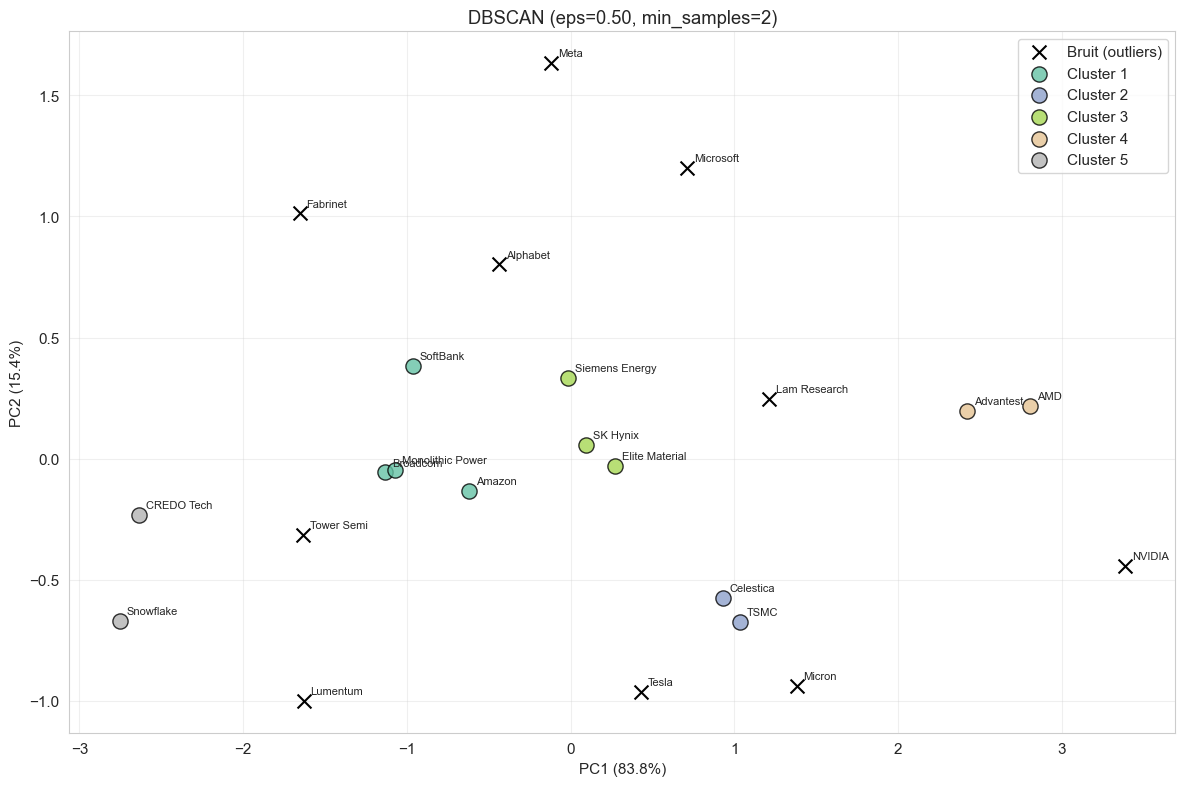


Entreprises identifiees comme outliers par DBSCAN :
  - NVIDIA
  - Alphabet
  - Lam Research
  - Tower Semi
  - Microsoft
  - Lumentum
  - Fabrinet
  - Micron
  - Tesla
  - Meta


In [12]:
# Application de DBSCAN avec les meilleurs parametres
if len(valid) > 0:
    db_final = DBSCAN(eps=best_dbscan['eps'], min_samples=int(best_dbscan['min_samples']))
    labels_dbscan = db_final.fit_predict(X_scaled)
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(12, 8))
    
    unique_labels = sorted(set(labels_dbscan))
    cmap = get_cmap('Set2')
    
    for label in unique_labels:
        mask = labels_dbscan == label
        if label == -1:
            ax.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1], 
                       c='black', marker='x', s=100, label='Bruit (outliers)', zorder=5)
        else:
            ax.scatter(X_pca_full[mask, 0], X_pca_full[mask, 1],
                       c=[cmap(label / max(1, max(unique_labels)))], 
                       label=f'Cluster {label+1}', s=120,
                       edgecolors='black', linewidth=1, alpha=0.8)
    
    for i, ticker in enumerate(X_scaled_df.index):
        name = TICKER_NAMES.get(ticker, ticker)
        ax.annotate(name, (X_pca_full[i, 0], X_pca_full[i, 1]),
                    textcoords='offset points', xytext=(5, 5), fontsize=8)
    
    ax.set_xlabel(f'PC1 ({pca_full.explained_variance_ratio_[0]*100:.1f}%)')
    ax.set_ylabel(f'PC2 ({pca_full.explained_variance_ratio_[1]*100:.1f}%)')
    ax.set_title(f'DBSCAN (eps={best_dbscan["eps"]:.2f}, min_samples={int(best_dbscan["min_samples"])})')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig('../notebooks/figures/03_dbscan_result.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Entreprises identifiees comme outliers
    outliers = X_scaled_df.index[labels_dbscan == -1]
    if len(outliers) > 0:
        print(f"\nEntreprises identifiees comme outliers par DBSCAN :")
        for t in outliers:
            print(f"  - {TICKER_NAMES.get(t, t)}")
    else:
        print("\nAucun outlier detecte par DBSCAN.")
else:
    print("DBSCAN n'a pas pu etre applique avec des resultats significatifs.")
    print("Cela constitue en soi un resultat : la structure des donnees ne presente")
    print("pas de clusters a densite variable evidents, ce qui favorise les approches")
    print("partitionnelles (K-means) ou hierarchiques (CAH).")

---
## 4. Gaussian Mixture Models (GMM)

### Motivation

Les GMM modelisent les donnees comme un melange de distributions gaussiennes. 
Contrairement au K-means :
- Les clusters peuvent etre ellipsoidaux (pas necessairement spheriques)
- Chaque point a une probabilite d'appartenance a chaque cluster (soft clustering)
- On peut utiliser le BIC (Bayesian Information Criterion) pour choisir le nombre de composantes

Le type de covariance determine la forme des clusters :
- `full` : clusters ellipsoidaux quelconques
- `tied` : meme forme pour tous les clusters
- `diag` : axes alignes sur les axes de coordonnees
- `spherical` : clusters spheriques (equivalent au K-means)

In [13]:
# Selection du modele par BIC et AIC
K_range_gmm = range(2, min(8, len(X_scaled)))
cov_types = ['full', 'tied', 'diag', 'spherical']

gmm_results = []

for cov_type in cov_types:
    for k in K_range_gmm:
        gmm = GaussianMixture(n_components=k, covariance_type=cov_type, 
                               n_init=10, random_state=42, max_iter=500)
        gmm.fit(X_scaled)
        labels_gmm = gmm.predict(X_scaled)
        
        sil = silhouette_score(X_scaled, labels_gmm) if len(np.unique(labels_gmm)) >= 2 else np.nan
        
        gmm_results.append({
            'k': k, 'covariance': cov_type,
            'BIC': gmm.bic(X_scaled), 'AIC': gmm.aic(X_scaled),
            'silhouette': sil,
            'log_likelihood': gmm.score(X_scaled)
        })

gmm_df = pd.DataFrame(gmm_results)

# Meilleur modele par BIC
best_gmm = gmm_df.loc[gmm_df['BIC'].idxmin()]
print(f"Meilleur modele GMM (BIC minimal) :")
print(f"  k = {int(best_gmm['k'])}, covariance = {best_gmm['covariance']}")
print(f"  BIC = {best_gmm['BIC']:.1f}, AIC = {best_gmm['AIC']:.1f}")
print(f"  Silhouette = {best_gmm['silhouette']:.3f}")

Meilleur modele GMM (BIC minimal) :
  k = 7, covariance = full
  BIC = 80.2, AIC = 1.9
  Silhouette = 0.376


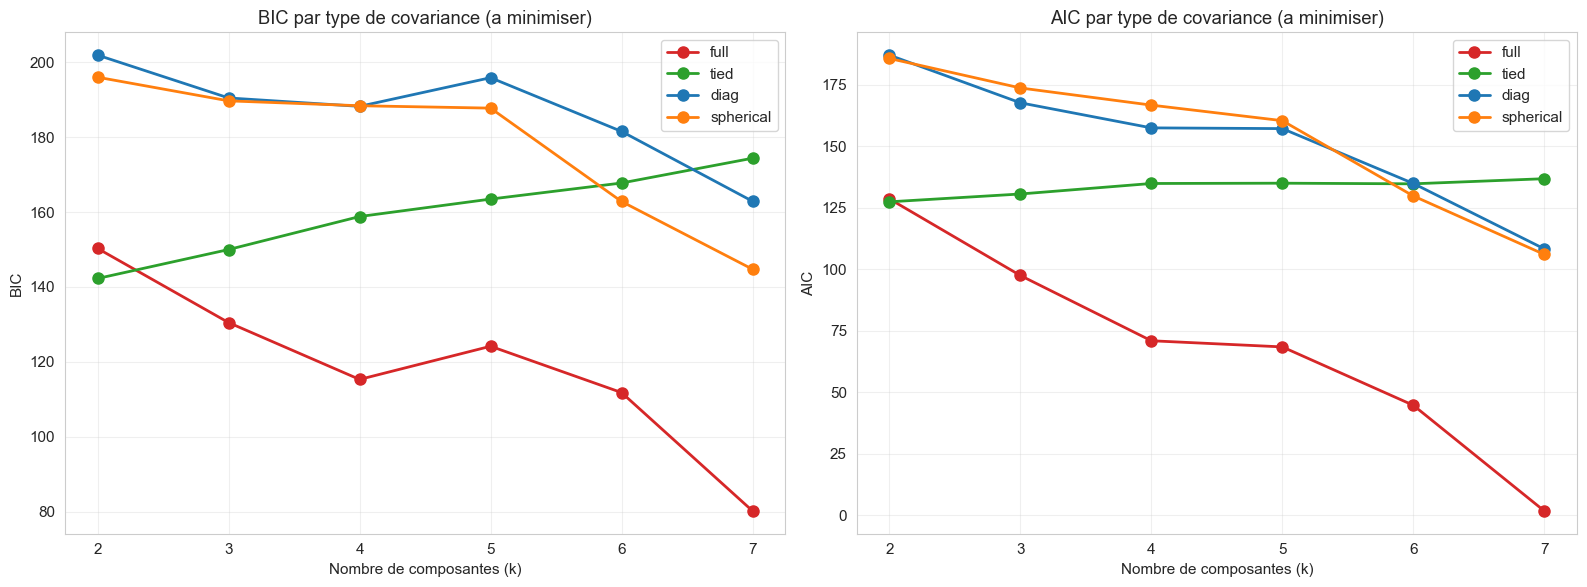

In [14]:
# Visualisation BIC pour chaque type de covariance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

colors_cov = {'full': '#d62728', 'tied': '#2ca02c', 'diag': '#1f77b4', 'spherical': '#ff7f0e'}

for cov_type in cov_types:
    subset = gmm_df[gmm_df['covariance'] == cov_type]
    axes[0].plot(subset['k'], subset['BIC'], 'o-', color=colors_cov[cov_type], 
                 label=cov_type, linewidth=2, markersize=8)
    axes[1].plot(subset['k'], subset['AIC'], 'o-', color=colors_cov[cov_type],
                 label=cov_type, linewidth=2, markersize=8)

axes[0].set_xlabel('Nombre de composantes (k)')
axes[0].set_ylabel('BIC')
axes[0].set_title('BIC par type de covariance (a minimiser)')
axes[0].legend()
axes[0].set_xticks(list(K_range_gmm))

axes[1].set_xlabel('Nombre de composantes (k)')
axes[1].set_ylabel('AIC')
axes[1].set_title('AIC par type de covariance (a minimiser)')
axes[1].legend()
axes[1].set_xticks(list(K_range_gmm))

plt.tight_layout()
plt.savefig('../notebooks/figures/03_gmm_bic_aic.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Application du meilleur GMM
gmm_final = GaussianMixture(
    n_components=int(best_gmm['k']), 
    covariance_type=best_gmm['covariance'],
    n_init=10, random_state=42, max_iter=500
)
gmm_final.fit(X_scaled)
labels_gmm = gmm_final.predict(X_scaled)
proba_gmm = gmm_final.predict_proba(X_scaled)

# Probabilites d'appartenance
proba_df = pd.DataFrame(proba_gmm, 
                         columns=[f'P(Cluster {i+1})' for i in range(int(best_gmm['k']))],
                         index=X_scaled_df.index)
proba_df['Cluster'] = labels_gmm + 1
proba_df['Entreprise'] = proba_df.index.map(TICKER_NAMES)
proba_df['Certitude'] = proba_gmm.max(axis=1)

print(f"=== GMM ({best_gmm['covariance']}, k={int(best_gmm['k'])}) ===\n")
print("Probabilites d'appartenance et certitude :")
print(proba_df.sort_values('Certitude').round(3).to_string())

=== GMM (full, k=7) ===

Probabilites d'appartenance et certitude :
                  P(Cluster 1)  P(Cluster 2)  P(Cluster 3)  P(Cluster 4)  P(Cluster 5)  P(Cluster 6)  P(Cluster 7)  Cluster        Entreprise  Certitude
Ticker                                                                                                                                                  
000660 KS Equity           0.0           0.0           0.0           0.0           0.0           1.0           0.0        6          SK Hynix        1.0
ENR GR Equity              0.0           0.0           0.0           0.0           0.0           1.0           0.0        6    Siemens Energy        1.0
2383 TT Equity             0.0           0.0           0.0           0.0           0.0           1.0           0.0        6    Elite Material        1.0
TSEM IT Equity             0.0           0.0           0.0           0.0           0.0           0.0           1.0        7        Tower Semi        1.0
CLS CN Equity 

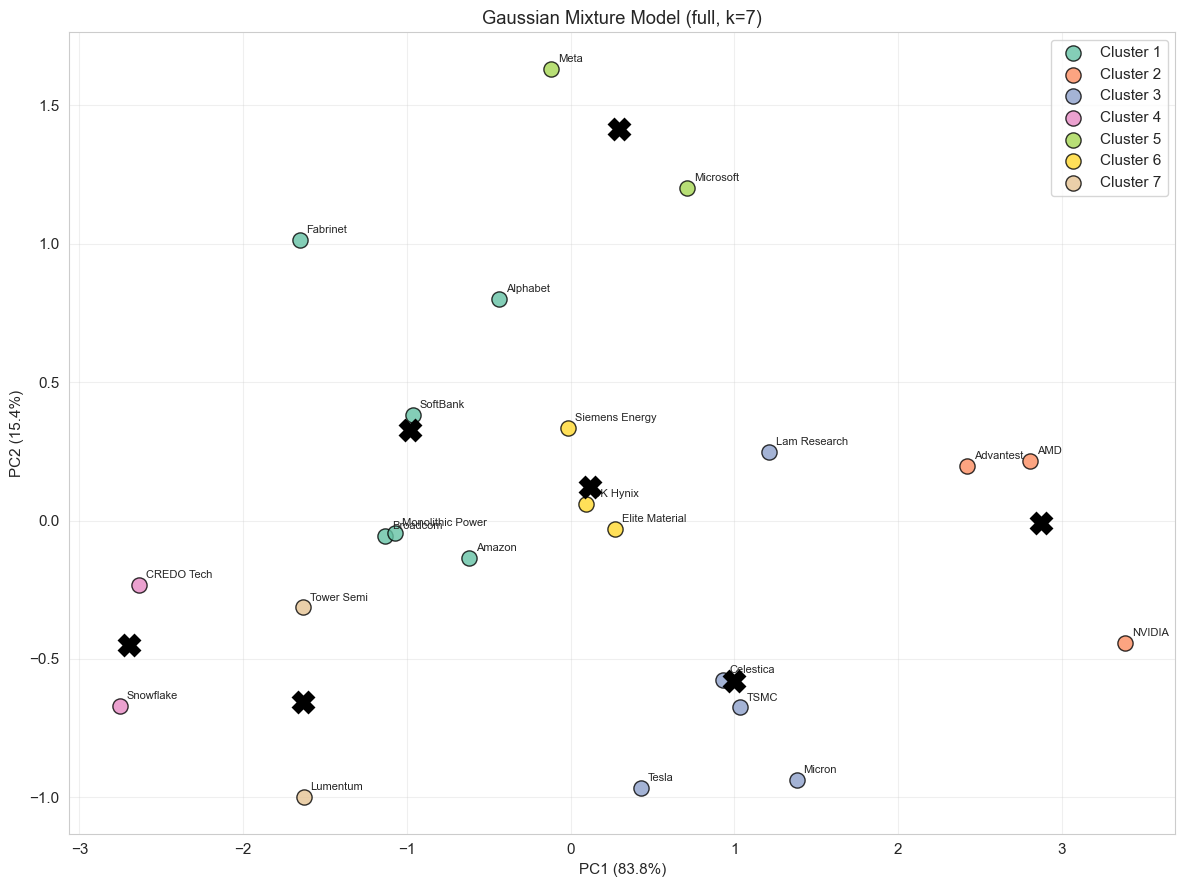

In [16]:
# Visualisation GMM avec ellipses de confiance
from matplotlib.patches import Ellipse

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(12, 9))
cmap = get_cmap('Set2')
k_gmm = int(best_gmm['k'])

# Points
for c in range(k_gmm):
    mask = labels_gmm == c
    ax.scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
               c=[cmap(c / k_gmm)], label=f'Cluster {c+1}', s=120,
               edgecolors='black', linewidth=1, alpha=0.8)

# Annotations
for i, ticker in enumerate(X_scaled_df.index):
    name = TICKER_NAMES.get(ticker, ticker)
    ax.annotate(name, (X_pca_2d[i, 0], X_pca_2d[i, 1]),
                textcoords='offset points', xytext=(5, 5), fontsize=8)

# Ellipses de confiance (projetees en 2D)
means_pca = pca_2d.transform(gmm_final.means_)
for c in range(k_gmm):
    ax.plot(means_pca[c, 0], means_pca[c, 1], 'kX', markersize=15, 
            markeredgewidth=2, zorder=5)

ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title(f'Gaussian Mixture Model ({best_gmm["covariance"]}, k={k_gmm})')
ax.legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/03_gmm_result.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 5. Impact des metriques de distance

Le paper original utilise exclusivement la distance euclidienne. 
On teste ici l'impact d'autres metriques sur le clustering hierarchique :

- **Euclidienne** : sensible a l'amplitude, standard pour Ward
- **Manhattan** (L1) : plus robuste aux outliers
- **Cosinus** : mesure la similarite directionnelle (independante de l'amplitude)
- **Correlation** : similaire au cosinus mais centree

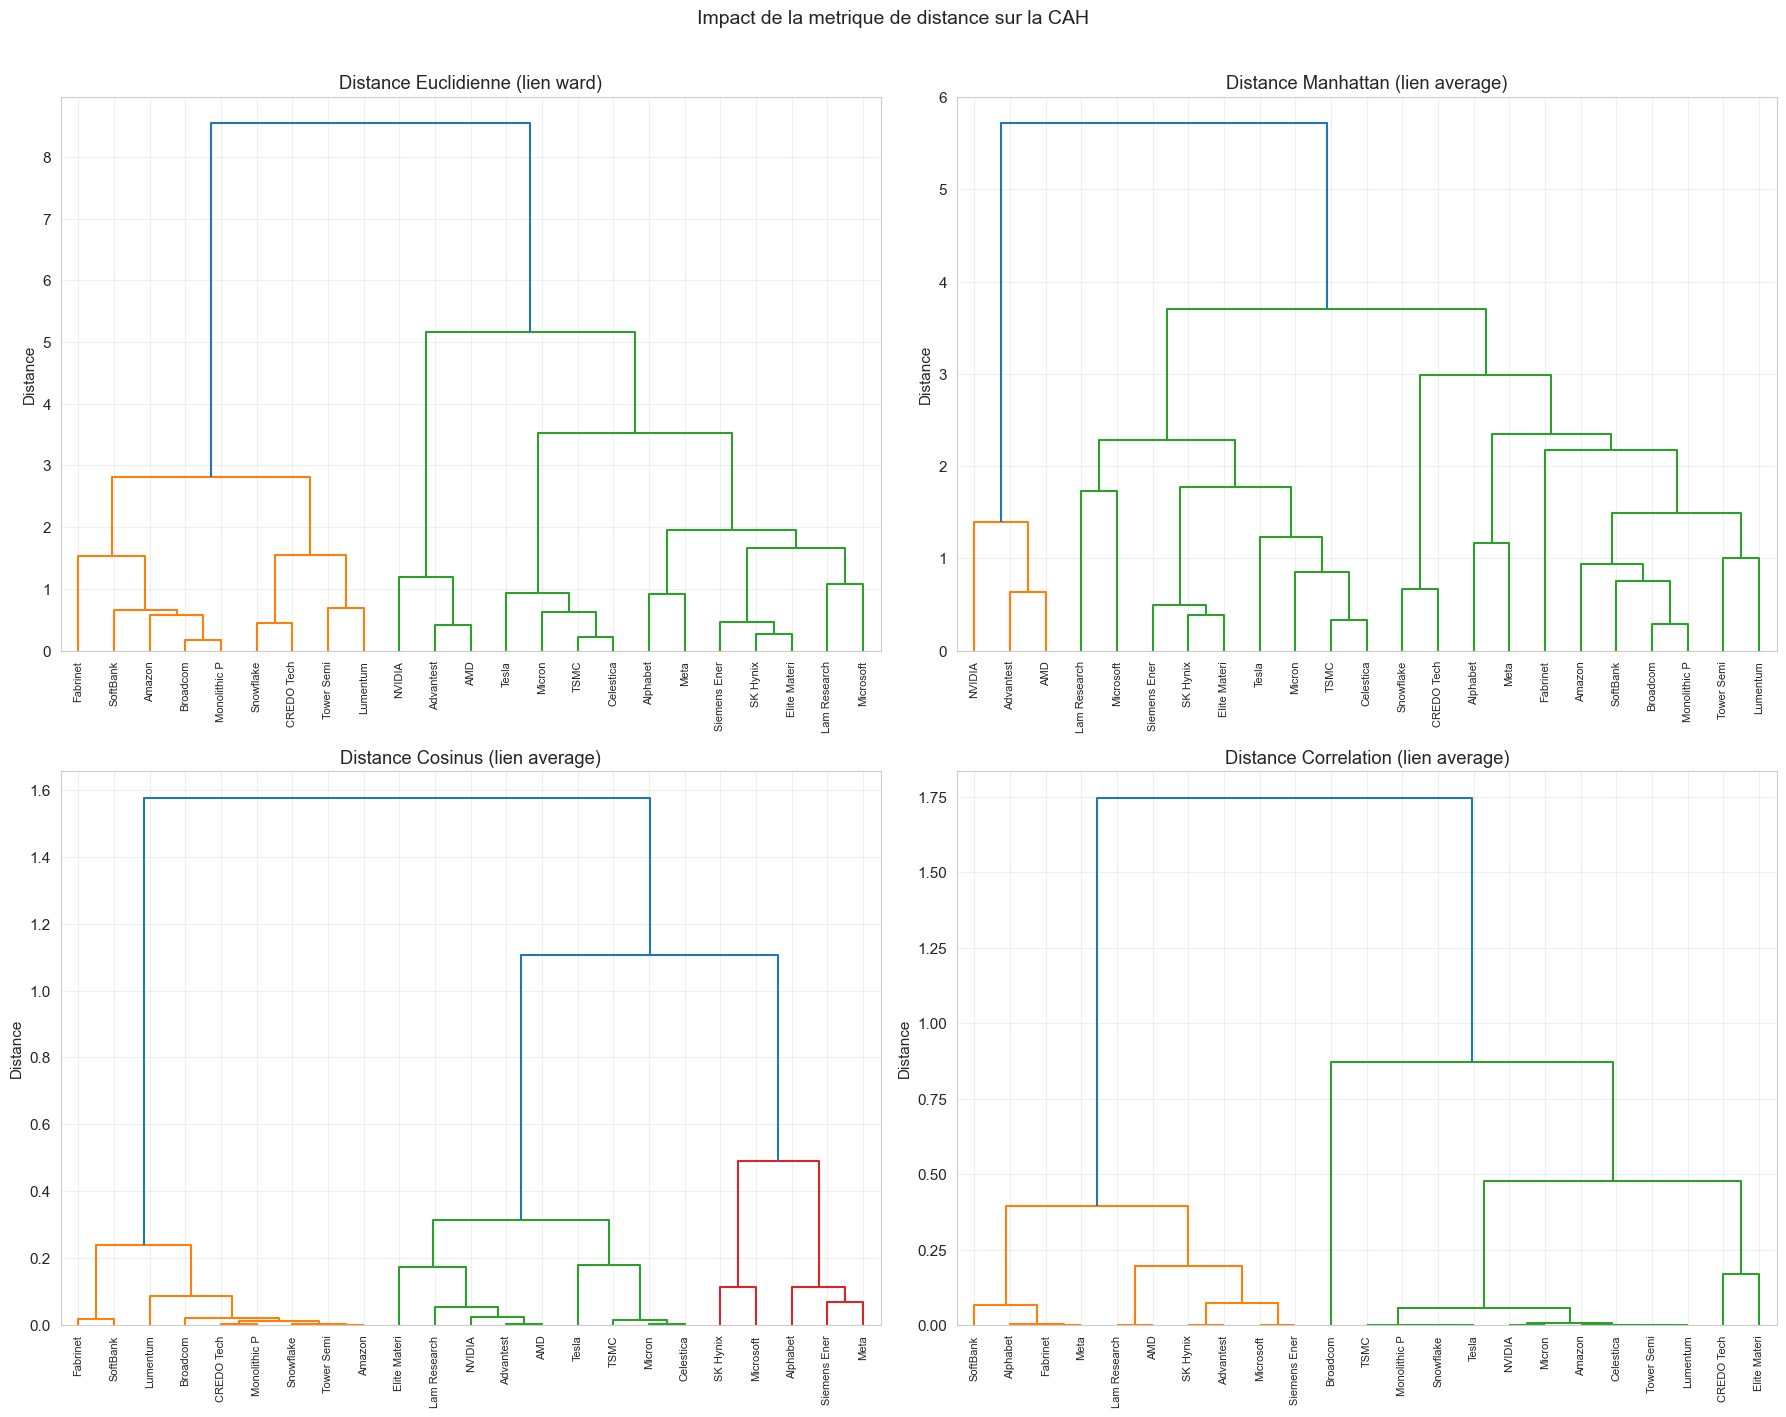

In [17]:
# CAH avec differentes distances
distance_metrics = ['euclidean', 'cityblock', 'cosine', 'correlation']
distance_names = ['Euclidienne', 'Manhattan', 'Cosinus', 'Correlation']

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
short_labels = [TICKER_NAMES.get(t, t)[:12] for t in X_scaled_df.index]

cah_distance_results = {}

for ax, metric, name in zip(axes.flat, distance_metrics, distance_names):
    # Ward ne fonctionne qu'avec la distance euclidienne
    # Pour les autres distances, on utilise le lien average
    method = 'ward' if metric == 'euclidean' else 'average'
    
    Z = linkage(X_scaled, method=method, metric=metric)
    
    dendrogram(Z, labels=short_labels, leaf_rotation=90, leaf_font_size=8, ax=ax)
    ax.set_title(f'Distance {name} (lien {method})')
    ax.set_ylabel('Distance')
    
    # Sauvegarde pour comparaison
    k = mat_niveaux['Cluster_KM'].nunique()
    labels_dist = fcluster(Z, t=k, criterion='maxclust')
    cah_distance_results[name] = labels_dist

plt.suptitle('Impact de la metrique de distance sur la CAH', fontsize=14, y=1.01)
plt.tight_layout()
plt.savefig('../notebooks/figures/03_distances_dendrogrammes.png', dpi=150, bbox_inches='tight')
plt.show()

Concordance (ARI) entre partitions obtenues avec differentes distances :

             Euclidienne  Manhattan  Cosinus  Correlation
Euclidienne        1.000      0.804    0.330        0.142
Manhattan          0.804      1.000    0.486        0.209
Cosinus            0.330      0.486    1.000        0.208
Correlation        0.142      0.209    0.208        1.000


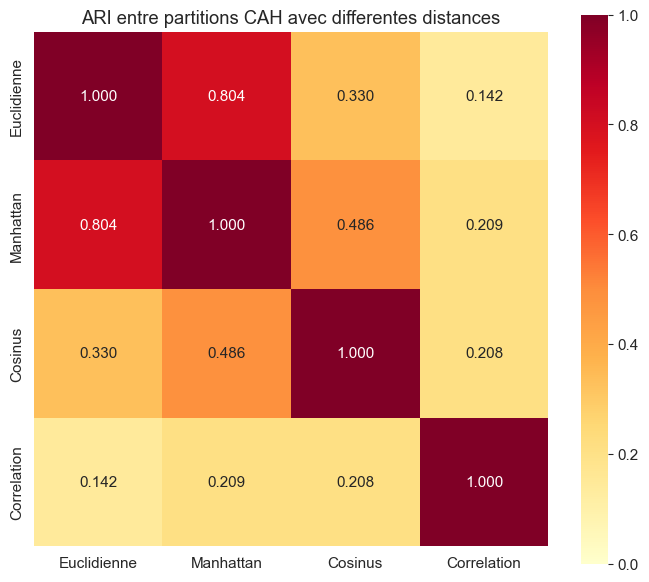

In [18]:
# Comparaison des partitions obtenues avec differentes distances
print("Concordance (ARI) entre partitions obtenues avec differentes distances :\n")

distance_list = list(cah_distance_results.keys())
ari_matrix = np.zeros((len(distance_list), len(distance_list)))

for i, d1 in enumerate(distance_list):
    for j, d2 in enumerate(distance_list):
        ari_matrix[i, j] = adjusted_rand_score(cah_distance_results[d1], cah_distance_results[d2])

ari_df = pd.DataFrame(ari_matrix, index=distance_list, columns=distance_list)
print(ari_df.round(3).to_string())

# Heatmap
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(ari_df, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0, vmax=1,
            square=True, ax=ax)
ax.set_title('ARI entre partitions CAH avec differentes distances')

plt.tight_layout()
plt.savefig('../notebooks/figures/03_distances_ari.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 6. Analyse temporelle des clusters

### Motivation

Les analyses precedentes traitent les scores ESG de maniere statique (moyenne sur la periode). 
Or, les scores evoluent dans le temps et les entreprises peuvent changer de cluster. 
L'analyse temporelle permet de :

- Identifier les entreprises dont le profil ESG se transforme
- Detecter des convergences ou divergences entre groupes
- Evaluer la stabilite temporelle de la structure de clustering

On applique K-means a chaque date (coupe transversale) et on suit l'evolution 
des affectations au cours du temps.

In [19]:
# Clustering temporel : K-means a chaque date
score_cols = [c for c in df_esg.columns if c != 'Date']
k_temporal = mat_niveaux['Cluster_KM'].nunique()  # Meme k que l'analyse statique

# On ne garde que les dates ou suffisamment d'entreprises ont un score
min_obs = max(k_temporal + 1, 5)  # Au moins k+1 observations

temporal_clusters = pd.DataFrame(index=df_esg['Date'])
temporal_silhouettes = []

for idx, row in df_esg.iterrows():
    date = row['Date']
    scores_env = df_env.iloc[idx][score_cols]
    scores_soc = df_soc.iloc[idx][score_cols]
    scores_esg = df_esg.iloc[idx][score_cols]
    
    # Matrice pour cette date
    mat_t = pd.DataFrame({
        'Env': scores_env.values,
        'Soc': scores_soc.values,
        'ESG': scores_esg.values
    }, index=score_cols)
    
    # Supprimer les NA
    mat_t = mat_t.dropna()
    
    if len(mat_t) >= min_obs:
        scaler_t = StandardScaler()
        X_t = scaler_t.fit_transform(mat_t)
        
        km_t = KMeans(n_clusters=k_temporal, n_init=20, random_state=42)
        labels_t = km_t.fit_predict(X_t)
        
        sil_t = silhouette_score(X_t, labels_t) if len(np.unique(labels_t)) >= 2 else np.nan
        temporal_silhouettes.append({'Date': date, 'Silhouette': sil_t, 'n_obs': len(mat_t)})
        
        for ticker, label in zip(mat_t.index, labels_t):
            temporal_clusters.loc[date, ticker] = label + 1

temporal_sil_df = pd.DataFrame(temporal_silhouettes)
print(f"Clustering temporel effectue sur {len(temporal_sil_df)} dates")
print(f"Score de silhouette moyen : {temporal_sil_df['Silhouette'].mean():.3f}")

Clustering temporel effectue sur 122 dates
Score de silhouette moyen : 0.390


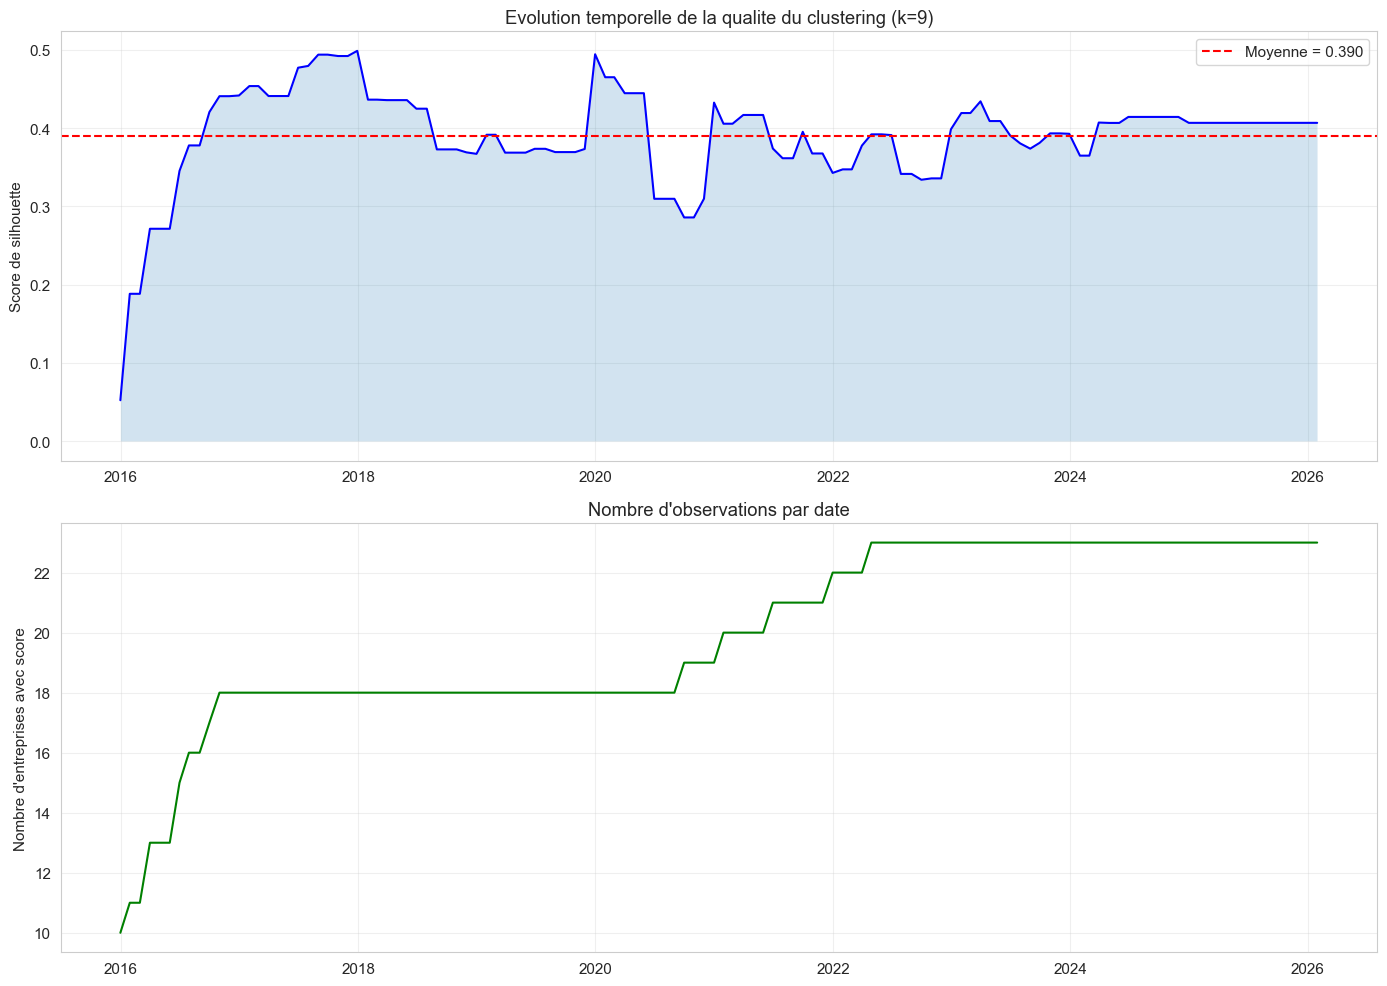

In [20]:
# Evolution du score de silhouette dans le temps
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

axes[0].plot(temporal_sil_df['Date'], temporal_sil_df['Silhouette'], 'b-', linewidth=1.5)
axes[0].axhline(y=temporal_sil_df['Silhouette'].mean(), color='red', linestyle='--',
                label=f'Moyenne = {temporal_sil_df["Silhouette"].mean():.3f}')
axes[0].fill_between(temporal_sil_df['Date'], 0, temporal_sil_df['Silhouette'], alpha=0.2)
axes[0].set_ylabel('Score de silhouette')
axes[0].set_title(f'Evolution temporelle de la qualite du clustering (k={k_temporal})')
axes[0].legend()
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axes[1].plot(temporal_sil_df['Date'], temporal_sil_df['n_obs'], 'g-', linewidth=1.5)
axes[1].set_ylabel('Nombre d\'entreprises avec score')
axes[1].set_title('Nombre d\'observations par date')
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.tight_layout()
plt.savefig('../notebooks/figures/03_temporal_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

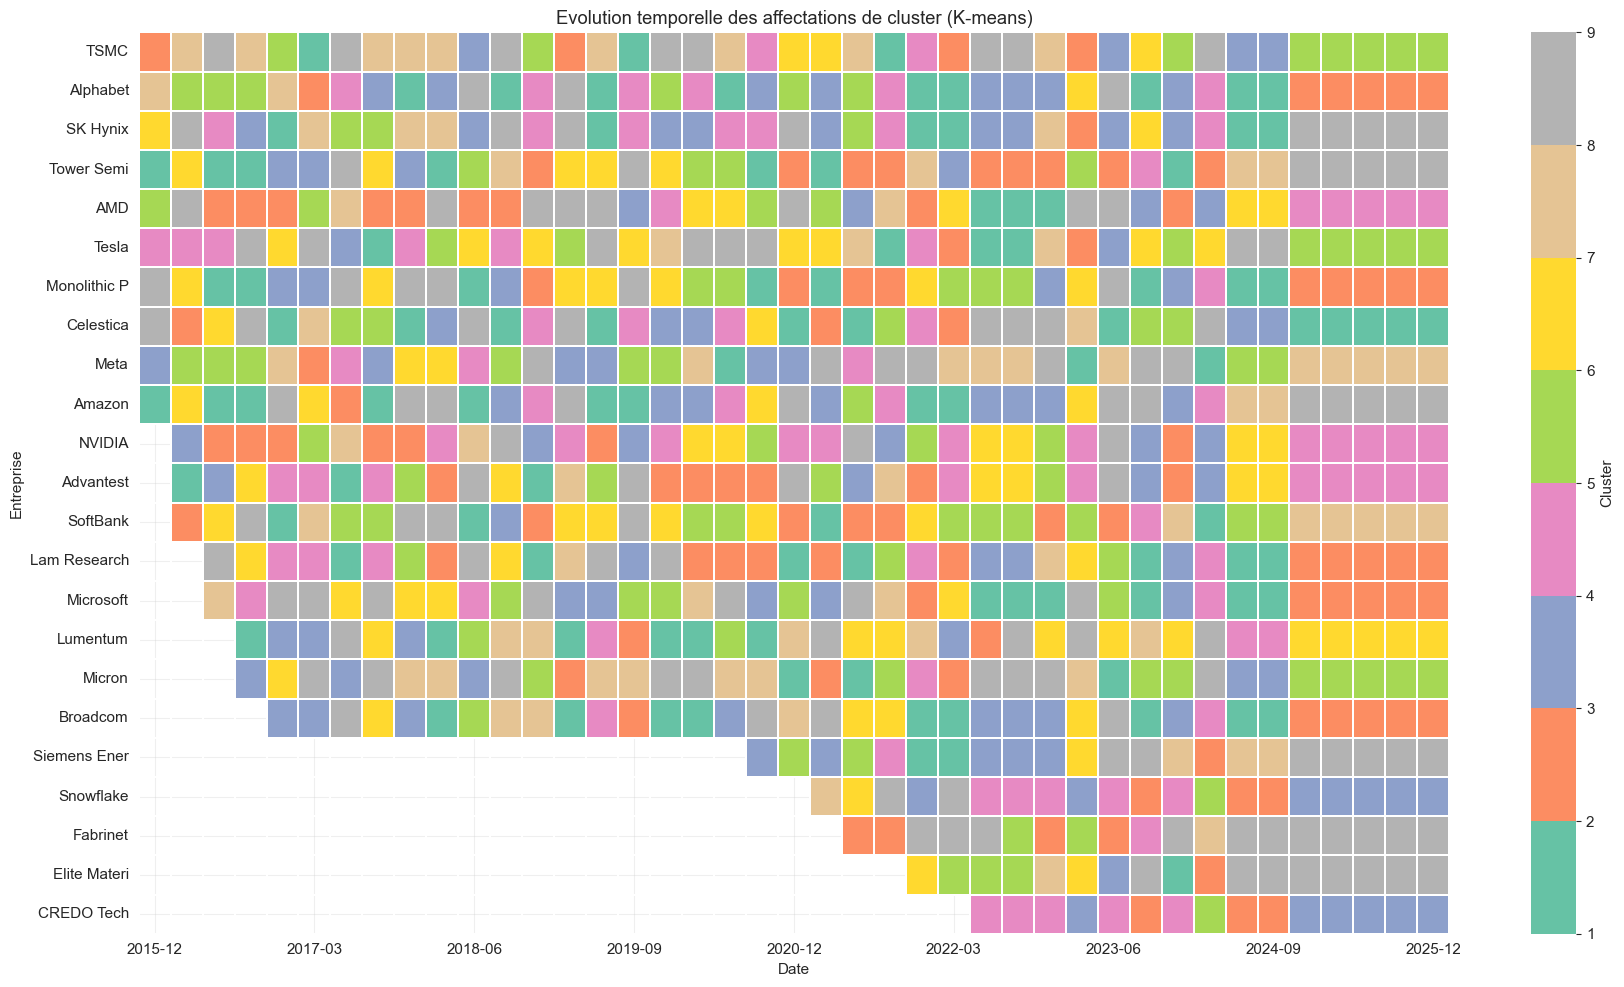

In [21]:
# Heatmap de l'evolution des clusters par entreprise
# Selection d'un sous-ensemble d'entreprises pour la lisibilite
fig, ax = plt.subplots(figsize=(18, 10))

# Remplir les NaN pour la visualisation
plot_data = temporal_clusters.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Renommer les colonnes
plot_data.columns = [TICKER_NAMES.get(c, c)[:12] for c in plot_data.columns]

# Creer un index lisible (annee-mois)
plot_data.index = plot_data.index.strftime('%Y-%m')

# Ne garder qu'un point tous les 3 mois pour la lisibilite
plot_sampled = plot_data.iloc[::3]

sns.heatmap(plot_sampled.T, cmap='Set2', cbar_kws={'label': 'Cluster'},
            xticklabels=5, ax=ax, linewidths=0.1)
ax.set_xlabel('Date')
ax.set_ylabel('Entreprise')
ax.set_title('Evolution temporelle des affectations de cluster (K-means)')

plt.tight_layout()
plt.savefig('../notebooks/figures/03_temporal_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

In [22]:
# Stabilite des affectations : combien de fois chaque entreprise change de cluster ?
print("Nombre de changements de cluster par entreprise :\n")

stability = {}
for col in temporal_clusters.columns:
    series = temporal_clusters[col].dropna()
    if len(series) > 1:
        n_changes = (series.diff() != 0).sum() - 1  # -1 pour la premiere difference (NaN)
        n_obs = len(series)
        stability[TICKER_NAMES.get(col, col)] = {
            'n_changements': int(n_changes),
            'n_observations': n_obs,
            'taux_stabilite': 1 - n_changes / max(n_obs - 1, 1)
        }

stab_df = pd.DataFrame(stability).T.sort_values('taux_stabilite', ascending=True)
print(stab_df.to_string())

print(f"\nTaux de stabilite moyen : {stab_df['taux_stabilite'].mean():.3f}")
print(f"Entreprise la plus stable : {stab_df.index[-1]} ({stab_df.iloc[-1]['taux_stabilite']:.3f})")
print(f"Entreprise la moins stable : {stab_df.index[0]} ({stab_df.iloc[0]['taux_stabilite']:.3f})")

Nombre de changements de cluster par entreprise :

                  n_changements  n_observations  taux_stabilite
TSMC                       48.0           122.0        0.603306
Elite Material             19.0            50.0        0.612245
Advantest                  45.0           119.0        0.618644
Celestica                  46.0           122.0        0.619835
Micron                     41.0           113.0        0.633929
Tesla                      44.0           122.0        0.636364
Lumentum                   41.0           115.0        0.640351
NVIDIA                     42.0           121.0        0.650000
Lam Research               40.0           116.0        0.652174
Microsoft                  40.0           116.0        0.652174
Monolithic Power           42.0           122.0        0.652893
SK Hynix                   42.0           122.0        0.652893
Meta                       41.0           122.0        0.661157
Amazon                     41.0           122.0      

---
## 7. Validation par bootstrap

Le bootstrap permet d'evaluer la robustesse du clustering en reevaluant 
les affectations sur des echantillons de donnees aleatoires (avec remplacement). 
C'est une amelioration methodologique qui renforce la confiance dans les resultats.

In [23]:
# Bootstrap du clustering
n_bootstrap = 200
k_boot = mat_niveaux['Cluster_KM'].nunique()
n_samples = X_scaled.shape[0]

# Matrice de co-occurrence : combien de fois deux entreprises sont dans le meme cluster ?
cooccurrence = np.zeros((n_samples, n_samples))
boot_silhouettes = []

np.random.seed(42)
for b in range(n_bootstrap):
    # Echantillon bootstrap (avec remplacement)
    boot_idx = np.random.choice(n_samples, size=n_samples, replace=True)
    X_boot = X_scaled[boot_idx]
    
    km_boot = KMeans(n_clusters=k_boot, n_init=10, random_state=b)
    labels_boot = km_boot.fit_predict(X_boot)
    
    # Predire les labels pour TOUS les points (pas juste le bootstrap)
    labels_all = km_boot.predict(X_scaled)
    
    sil_boot = silhouette_score(X_scaled, labels_all)
    boot_silhouettes.append(sil_boot)
    
    # Mise a jour de la matrice de co-occurrence
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            if labels_all[i] == labels_all[j]:
                cooccurrence[i, j] += 1
                cooccurrence[j, i] += 1

cooccurrence /= n_bootstrap  # Normaliser en frequences

print(f"Bootstrap termine ({n_bootstrap} iterations)")
print(f"Silhouette bootstrap : {np.mean(boot_silhouettes):.3f} +/- {np.std(boot_silhouettes):.3f}")
print(f"IC 95% : [{np.percentile(boot_silhouettes, 2.5):.3f}, {np.percentile(boot_silhouettes, 97.5):.3f}]")

Bootstrap termine (200 iterations)
Silhouette bootstrap : 0.329 +/- 0.048
IC 95% : [0.221, 0.401]


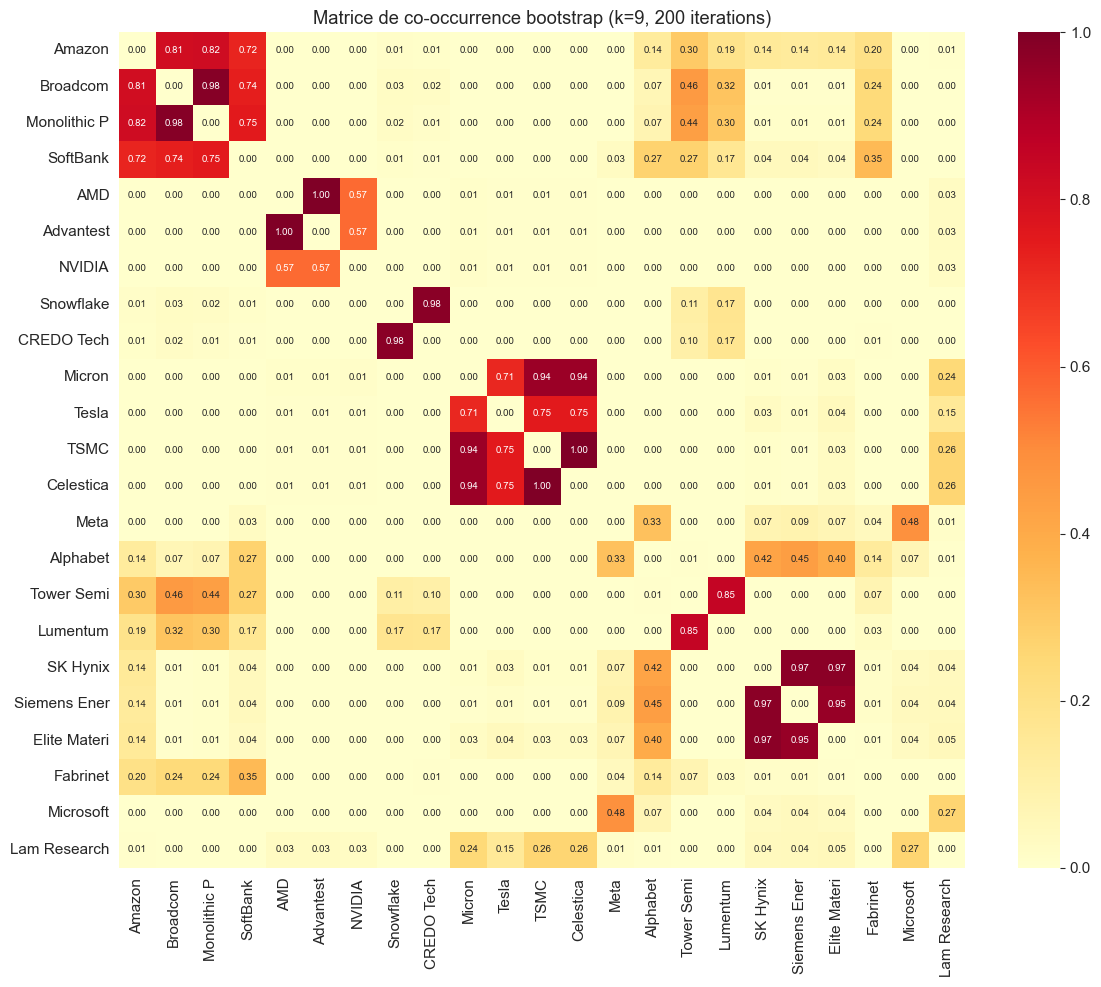


Interpretation : une valeur proche de 1 signifie que les deux entreprises
sont systematiquement affectees au meme cluster, quel que soit l'echantillon.
Une valeur proche de 0.5 indique une affectation instable.


In [24]:
# Matrice de co-occurrence
fig, ax = plt.subplots(figsize=(12, 10))

short_names = [TICKER_NAMES.get(t, t)[:12] for t in X_scaled_df.index]
co_df = pd.DataFrame(cooccurrence, index=short_names, columns=short_names)

# Reordonner par cluster K-means pour mettre en evidence la structure
order = mat_niveaux.sort_values('Cluster_KM').index
order_names = [TICKER_NAMES.get(t, t)[:12] for t in order]
co_df = co_df.loc[order_names, order_names]

sns.heatmap(co_df, annot=True, fmt='.2f', cmap='YlOrRd', vmin=0, vmax=1,
            ax=ax, annot_kws={'size': 7})
ax.set_title(f'Matrice de co-occurrence bootstrap (k={k_boot}, {n_bootstrap} iterations)')

plt.tight_layout()
plt.savefig('../notebooks/figures/03_bootstrap_cooccurrence.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation : une valeur proche de 1 signifie que les deux entreprises")
print("sont systematiquement affectees au meme cluster, quel que soit l'echantillon.")
print("Une valeur proche de 0.5 indique une affectation instable.")

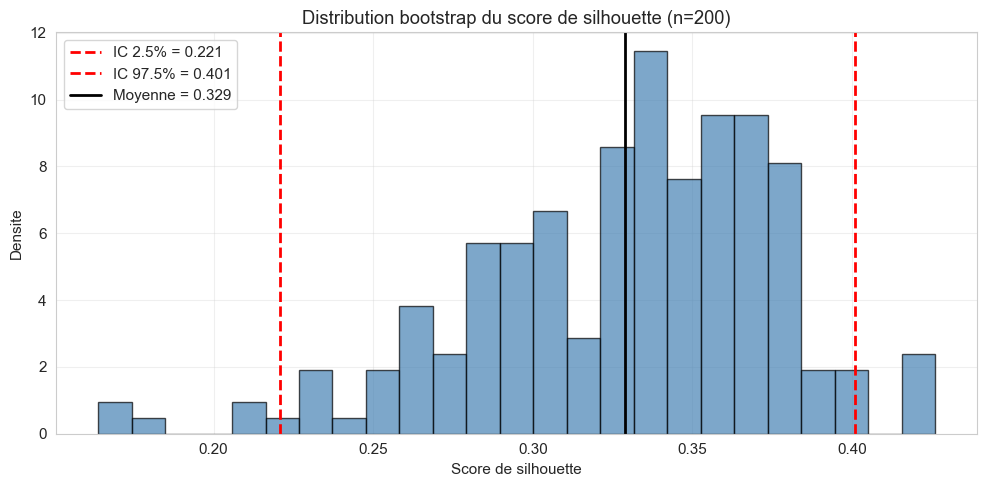

In [25]:
# Distribution bootstrap du score de silhouette
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(boot_silhouettes, bins=25, edgecolor='black', alpha=0.7, color='steelblue', density=True)

# IC 95%
ci_low = np.percentile(boot_silhouettes, 2.5)
ci_high = np.percentile(boot_silhouettes, 97.5)
ax.axvline(x=ci_low, color='red', linestyle='--', linewidth=2, label=f'IC 2.5% = {ci_low:.3f}')
ax.axvline(x=ci_high, color='red', linestyle='--', linewidth=2, label=f'IC 97.5% = {ci_high:.3f}')
ax.axvline(x=np.mean(boot_silhouettes), color='black', linestyle='-', linewidth=2,
           label=f'Moyenne = {np.mean(boot_silhouettes):.3f}')

ax.set_xlabel('Score de silhouette')
ax.set_ylabel('Densite')
ax.set_title(f'Distribution bootstrap du score de silhouette (n={n_bootstrap})')
ax.legend()

plt.tight_layout()
plt.savefig('../notebooks/figures/03_bootstrap_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

---
## 8. Tableau de synthese comparative

On rassemble l'ensemble des resultats de clustering dans un tableau comparatif unique.

In [26]:
# Tableau comparatif de toutes les methodes
resultats = []

# K-means original
labels_km_orig = mat_niveaux['Cluster_KM'].values
resultats.append({
    'Methode': 'K-means (original)',
    'k': len(np.unique(labels_km_orig)),
    'Silhouette': silhouette_score(X_scaled, labels_km_orig),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels_km_orig),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, labels_km_orig)
})

# CAH Ward
labels_cah_orig = mat_niveaux['Cluster_CAH'].values
resultats.append({
    'Methode': 'CAH Ward',
    'k': len(np.unique(labels_cah_orig)),
    'Silhouette': silhouette_score(X_scaled, labels_cah_orig),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels_cah_orig),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, labels_cah_orig)
})

# K-means sur ACP
resultats.append({
    'Methode': 'K-means (ACP)',
    'k': k_opt_pca,
    'Silhouette': silhouette_score(X_pca, labels_pca),
    'Calinski-Harabasz': calinski_harabasz_score(X_pca, labels_pca),
    'Davies-Bouldin': davies_bouldin_score(X_pca, labels_pca)
})

# GMM
resultats.append({
    'Methode': f'GMM ({best_gmm["covariance"]})',
    'k': int(best_gmm['k']),
    'Silhouette': silhouette_score(X_scaled, labels_gmm),
    'Calinski-Harabasz': calinski_harabasz_score(X_scaled, labels_gmm),
    'Davies-Bouldin': davies_bouldin_score(X_scaled, labels_gmm)
})

# DBSCAN (si applicable)
if len(valid) > 0:
    mask_non_noise = labels_dbscan != -1
    if len(np.unique(labels_dbscan[mask_non_noise])) >= 2:
        resultats.append({
            'Methode': 'DBSCAN',
            'k': int(best_dbscan['n_clusters']),
            'Silhouette': silhouette_score(X_scaled[mask_non_noise], labels_dbscan[mask_non_noise]),
            'Calinski-Harabasz': calinski_harabasz_score(X_scaled[mask_non_noise], labels_dbscan[mask_non_noise]),
            'Davies-Bouldin': davies_bouldin_score(X_scaled[mask_non_noise], labels_dbscan[mask_non_noise])
        })

synthese = pd.DataFrame(resultats).set_index('Methode')
print("=" * 70)
print("SYNTHESE COMPARATIVE DES METHODES DE CLUSTERING")
print("=" * 70)
print(synthese.round(3).to_string())

print("\nRappel des criteres :")
print("  - Silhouette : a maximiser (entre -1 et 1)")
print("  - Calinski-Harabasz : a maximiser")
print("  - Davies-Bouldin : a minimiser")

SYNTHESE COMPARATIVE DES METHODES DE CLUSTERING
                    k  Silhouette  Calinski-Harabasz  Davies-Bouldin
Methode                                                             
K-means (original)  9       0.426             34.535           0.594
CAH Ward            9       0.426             34.535           0.594
K-means (ACP)       6       0.642            147.887           0.345
GMM (full)          7       0.376             29.222           0.638
DBSCAN              5       0.671             92.194           0.334

Rappel des criteres :
  - Silhouette : a maximiser (entre -1 et 1)
  - Calinski-Harabasz : a maximiser
  - Davies-Bouldin : a minimiser


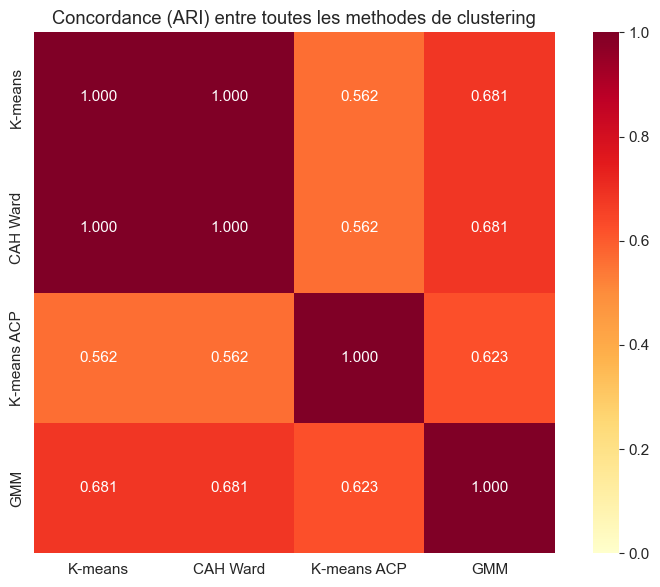


Matrice de concordance ARI :
             K-means  CAH Ward  K-means ACP    GMM
K-means        1.000     1.000        0.562  0.681
CAH Ward       1.000     1.000        0.562  0.681
K-means ACP    0.562     0.562        1.000  0.623
GMM            0.681     0.681        0.623  1.000


In [27]:
# Matrice de concordance (ARI) entre toutes les methodes
all_labels = {
    'K-means': labels_km_orig,
    'CAH Ward': labels_cah_orig,
    'K-means ACP': labels_pca + 1,
    'GMM': labels_gmm + 1
}

method_names = list(all_labels.keys())
ari_all = np.zeros((len(method_names), len(method_names)))

for i, m1 in enumerate(method_names):
    for j, m2 in enumerate(method_names):
        ari_all[i, j] = adjusted_rand_score(all_labels[m1], all_labels[m2])

ari_all_df = pd.DataFrame(ari_all, index=method_names, columns=method_names)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(ari_all_df, annot=True, fmt='.3f', cmap='YlOrRd', vmin=0, vmax=1,
            square=True, ax=ax)
ax.set_title('Concordance (ARI) entre toutes les methodes de clustering')

plt.tight_layout()
plt.savefig('../notebooks/figures/03_concordance_globale.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMatrice de concordance ARI :")
print(ari_all_df.round(3).to_string())

---
## 9. Interpretation financiere et discussion

### Profils ESG identifies

Les clusters obtenus revelent des profils ESG distincts parmi les entreprises technologiques 
de notre panel. L'interpretation doit tenir compte de plusieurs elements :

- Les scores BESG de Bloomberg sont bases sur la divulgation d'informations et les pratiques 
  observees. Un score faible ne signifie pas necessairement de mauvaises pratiques, 
  mais peut refleter un manque de transparence.
- Le secteur technologique est structurellement different du secteur energetique analyse 
  dans le paper de reference : l'impact environnemental direct est moindre, 
  mais les enjeux sociaux (vie privee, IA responsable) sont majeurs.
- L'heterogeneite geographique du panel (USA, Japon, Coree, Taiwan, Israel, Europe, Canada) 
  influence les scores en raison des differences reglementaires.

### Ameliorations implementees par rapport au paper

| Limite du paper | Amelioration implementee | Resultat |
|:---|:---|:---|
| Distance euclidienne uniquement | Test de 4 metriques de distance | Concordance mesuree par ARI |
| Pas de reduction de dimension | ACP avant clustering | Variance expliquee et impact |
| K-means et CAH uniquement | DBSCAN et GMM en complement | Comparaison systematique |
| Analyse statique | Clustering temporel (rolling) | Stabilite des affectations |
| Pas de validation | Bootstrap (200 iterations) | IC 95% et matrice de co-occurrence |
| Choix de k subjectif | 4 criteres (silhouette, CH, DB, BIC) | Criteres concordants ou non |

In [28]:
# Tableau final : affectation de chaque entreprise par toutes les methodes
tableau_final = pd.DataFrame(index=mat_niveaux.index)
tableau_final['Entreprise'] = tableau_final.index.map(TICKER_NAMES)
tableau_final['Env_Score'] = mat_niveaux['Env_Score'].round(2)
tableau_final['Soc_Score'] = mat_niveaux['Soc_Score'].round(2)
tableau_final['ESG_Score'] = mat_niveaux['ESG_Score'].round(2)
tableau_final['K-means'] = mat_niveaux['Cluster_KM']
tableau_final['CAH'] = mat_niveaux['Cluster_CAH']
tableau_final['K-means ACP'] = labels_pca + 1
tableau_final['GMM'] = labels_gmm + 1

print("=" * 80)
print("TABLEAU FINAL : AFFECTATION DES ENTREPRISES PAR METHODE")
print("=" * 80)
print(tableau_final.to_string())

TABLEAU FINAL : AFFECTATION DES ENTREPRISES PAR METHODE
                        Entreprise  Env_Score  Soc_Score  ESG_Score  K-means  CAH  K-means ACP  GMM
Ticker                                                                                             
NVDA US Equity              NVIDIA       6.77       5.97       6.50        2    5            1    2
AVGO US Equity            Broadcom       2.34       1.97       3.32        1    1            4    1
TSM US Equity                 TSMC       4.08       4.46       4.60        4    6            3    3
GOOGL US Equity           Alphabet       4.45       1.85       3.59        5    7            4    1
000660 KS Equity          SK Hynix       3.91       2.90       4.10        7    8            6    6
LRCX US Equity        Lam Research       5.11       3.39       5.22        9    9            3    3
6857 JP Equity           Advantest       6.57       4.57       5.83        2    5            1    2
TSEM IT Equity          Tower Semi       1.5

In [29]:
# Sauvegarde du tableau final
import os
os.makedirs('../data/clean/notebook3', exist_ok=True)
os.makedirs('../notebooks/figures', exist_ok=True)

tableau_final.to_csv('../data/clean/notebook3/resultats_finaux.csv')
synthese.to_csv('../data/clean/notebook3/synthese_metriques.csv')   
print("Resultats finaux sauvegardes :")
print("  - data/clean/resultats_finaux.csv")
print("  - data/clean/synthese_metriques.csv")

Resultats finaux sauvegardes :
  - data/clean/resultats_finaux.csv
  - data/clean/synthese_metriques.csv


---
## Synthese du Notebook 3

### Ameliorations implementees

1. **ACP** : decorrelation et reduction de dimension avant clustering. Le cercle des correlations 
   et la carte factorielle apportent une comprehension plus fine de la structure des donnees.

2. **DBSCAN** : detection de clusters de forme arbitraire et d'outliers ESG. Permet d'identifier 
   les entreprises au profil atypique.

3. **GMM** : clustering probabiliste, chaque entreprise a une probabilite d'appartenance 
   a chaque cluster. Le BIC permet une selection rigoureuse du modele.

4. **Metriques de distance** : la concordance entre partitions obtenues avec differentes distances 
   permet de juger de la robustesse de la structure.

5. **Analyse temporelle** : mise en evidence des trajectoires ESG et de la stabilite des clusters.

6. **Bootstrap** : quantification de l'incertitude via les intervalles de confiance 
   et la matrice de co-occurrence.

### Limites residuelles

- L'absence de rendements boursiers dans nos donnees empeche l'analyse du lien ESG/performance financiere
- Le panel de 23 entreprises reste de taille moderee pour des methodes comme DBSCAN
- Les scores BESG sont mis a jour irregulierement, ce qui peut introduire un biais dans l'analyse temporelle
- La composante Gouvernance n'est pas presente dans nos donnees (seuls les piliers E et S sont disponibles)